In [1]:
import os
import numpy as np
import pandas as pd
from prettytable import PrettyTable
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

In [2]:
import reading_util as ru
import string_constants as sc
import quantile_regression_dnn as qr
import loss_strategy as lo
import plotting_util as pu
import parameter as pa

Using TensorFlow backend.


# model (change!)

In [3]:
regr_cut = True

In [4]:
fig_dir_base = 'fig/analysis_quantile_regression/regression' + ('_cut' if regr_cut else '_full')
!mkdir -p $fig_dir_base

# read in qcd data

In [5]:
SM_sample = 'qcdSigAll'

In [6]:
qcd_path = os.path.join( sc.concat_result_dir, sc.sample_loc[SM_sample] + sc.concat_result_suffix )
qcd_data_total, labels = ru.read_results_to_recarray( qcd_path )

In [7]:
print(qcd_data_total.shape)

(5269561,)


In [8]:
# split qcd data in QR train and selection testset
QR_train_share = 0.25 #0.2
qcd_n_evts = qcd_data_total.shape[0]
qcd_data_train = qcd_data_total[:int(qcd_n_evts*QR_train_share)]
qcd_data_test = qcd_data_total[int(qcd_n_evts*QR_train_share):]

In [9]:
print('training on ' + str(qcd_data_train.shape[0]) + ' events')
print('testing on ' + str(qcd_data_test.shape[0]) + ' events')

training on 1317390 events
testing on 3952171 events


## plot qcd mass spectrum for training set and testing set

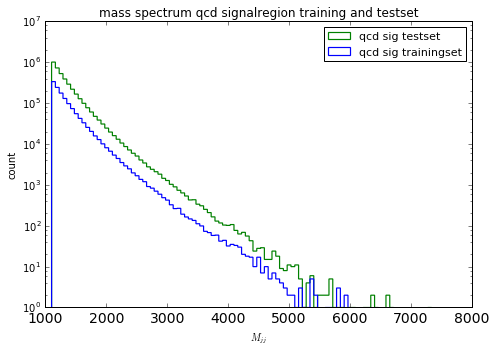

In [10]:
_ = pu.plot_hist( [qcd_data_train['mJJ'], qcd_data_test['mJJ']], xlabel=r'$M_{jj}$', \
                 legend=['qcd sig trainingset','qcd sig testset'], normed=False, ylabel='count', \
                 title='mass spectrum qcd signalregion training and testset')

# read in signal data and test qcd data

In [9]:
BSM_samples = ['GtoWW15na', 'GtoWW20na', 'GtoWW25na', 'GtoWW30na', 'GtoWW35na', 'GtoWW40na', 'GtoWW45na', \
              'GtoWW15br', 'GtoWW20br', 'GtoWW25br', 'GtoWW30br', 'GtoWW35br', 'GtoWW40br', 'GtoWW45br']
all_samples = [SM_sample] + BSM_samples

In [10]:
result_data = {}

result_data[SM_sample] = qcd_data_total[int(qcd_n_evts*QR_train_share):] # all of qcd already read in, take test share 

for n in BSM_samples:
    sample, labels = ru.read_results_to_recarray( os.path.join( sc.concat_result_dir, sc.sample_loc[n] + sc.concat_result_suffix ) )
    print(n,": ",sample.shape[0],"events")
    result_data[n] = sample

('GtoWW15na', ': ', 448032, 'events')
('GtoWW20na', ': ', 477149, 'events')
('GtoWW25na', ': ', 512505, 'events')
('GtoWW30na', ': ', 530775, 'events')
('GtoWW35na', ': ', 488137, 'events')
('GtoWW40na', ': ', 530031, 'events')
('GtoWW45na', ': ', 432356, 'events')
('GtoWW15br', ': ', 394521, 'events')
('GtoWW20br', ': ', 446043, 'events')
('GtoWW25br', ': ', 472902, 'events')
('GtoWW30br', ': ', 486192, 'events')
('GtoWW35br', ': ', 498566, 'events')
('GtoWW40br', ': ', 503838, 'events')
('GtoWW45br', ': ', 517498, 'events')


# define analysis parameters

In [11]:
#loss_strategies = ['s1','s2','s3','s4','s5']
loss_strategies = ['s5']

In [12]:
#quantiles = ['q1','q2','q5','q10','q25','q50','q75','q90','q99']
quantiles = ['q1']

# define plot / table functions

In [13]:
def make_fig_dir( quant, strat ):
    fig_dir_ext = os.path.join(fig_dir_base,strat.path_str,quant.path_str)
    !mkdir -p $fig_dir_ext
    return fig_dir_ext

In [14]:
def plot_qr_2d_hist( qcd_data, loss, model, quantile, strategy, fig_dir ):
    Mjj_selection = 1100.
    plt.figure(figsize=(8, 8))
    x_min = Mjj_selection*0.8
    x_max = 7000. #np.percentile(x, 99.99)
    plt.hist2d(qcd_data['mJJ'], loss,
           range=((x_min , x_max), (np.min(loss), np.percentile(loss, 1e2*(1-1e-4)))), 
           norm=LogNorm(), bins=100, label='signal data')

    xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
    plt.plot(xs, model.predict( xs ) , '-', color='m', lw=2.5, label='QR selection')
    if regr_cut:
        plt.plot(xs, model.predict(np.minimum(xs,max_acc_mjj)) , '-', color='purple', lw=3, label='QR selection cut')
    
    plt.ylabel(strategy.title_str)
    plt.xlabel('$M_{jj}$ [GeV]')
    plt.title('qcd signal region '+ quantile.title_str +' QR training data')
    plt.colorbar()
    plt.legend(loc='best')
    plt.draw()
    plt.savefig(os.path.join(fig_dir,'qcd_selection_training_hist2d.png'))

In [15]:
def plot_acc_vs_rej_hist(name, data, selection, fig_dir):
    accepted = data[ selection ]
    rejected = data[ ~selection ]
    xx = [data['mJJ'], accepted['mJJ'], rejected['mJJ']]
    plot_name = name+'_event_selection'
    [h_t, h_a, h_r], _ = \
        pu.plot_hist( xx, xlabel='M_jj', bins=100, title='event selection ' + name, fig_dir=fig_dir, plot_name=plot_name, legend=['total','accepted','rejected'], normed=False)

In [16]:
def print_table( results, quantiles, loss_strategies ):
    
    date = datetime.date.today().strftime("%m%d")
    with open(fig_dir_base+'/eff_tables_'+date+'.txt','w') as f:
        
        for quant in quantiles:
            eff = results[quant]
            table = PrettyTable(['sample'] + [ pa.loss_strategy_dict[l].title_str for l in loss_strategies ])
            for n in all_samples:
                eff_fmt = ['{:.2f}'.format(e) for e in eff[n].values]
                table.add_row([n] + eff_fmt)
            table_title = '\n'+'+'*30 + '\n\t' + pa.quantile_dict[quant].title_str + '\n\n'
            print(table_title)
            print(table)
            f.write(table_title)
            f.write(str(table))

In [17]:
from matplotlib.pyplot import cm

def plot_eff_vs_mjj( analysis, quantiles, loss_strategies ):
    
    for q in quantiles:
        
        eff = analysis[q]
    
        narrows = np.array( [ eff[k].values for k in BSM_samples if 'na' in k ] )
        broads = np.array( [ eff[k].values for k in BSM_samples if 'br' in k ] )

        color = cm.jet(np.linspace(0,1,len(loss_strategies)))

        plt.figure(figsize=(8, 8))

        xx = [1.5,2.0,2.5,3.0,3.5,4.0,4.5]

        for i, strat in enumerate([ pa.loss_strategy_dict[l].title_str for l in loss_strategies ]):
            plt.plot( xx, narrows[:,i], label='narrow ' + strat, color=color[i], linestyle='-', lw=1.5 )
            plt.plot( xx, broads[:,i], label='broad ' + strat, color=color[i], linestyle='dashed', lw=1.5 )      

        plt.axhline(y=pa.quantile_dict[q].val*100, color='grey', linestyle='dotted', lw=3.0)
            
        plt.grid(axis='y', linewidth=0.4)
        plt.ylabel('efficiency %')
        plt.ylim(bottom=max(0.0, pa.quantile_dict[q].val*100-5))
        plt.xlabel('$M_{jj}$ [GeV]')
        plt.title('sample efficiency '+ pa.quantile_dict[q].title_str)
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.draw()
        plt.savefig(os.path.join(fig_dir_base,'efficiency_plt_'+ pa.quantile_dict[q].path_str+'.png'), bbox_inches="tight")

In [18]:
def plot_eff_enhanced_vs_quantile( analysis, quantiles, loss_strategies ):
    
    xx = [ pa.quantile_dict[q].val for q in quantiles ]
    color = cm.jet(np.linspace(0,1,len(BSM_samples)))
    
    for i, s in enumerate(loss_strategies):
        
        loss_eff = analysis.iloc[i] / 100.0 # TODO: change saving selected-N and total-N and computing eficiency on the fly
        qcd_eff = loss_eff[:,SM_sample].values
        
        plt.figure(figsize=(8, 8))
        
        for i,n in enumerate(BSM_samples):
            if 'na' in n:
                plt.plot( xx, loss_eff[:,n].values / np.sqrt( qcd_eff ), label=n, color=color[i], linestyle='-', lw=1.5)
            else:
                plt.plot( xx, loss_eff[:,n].values / np.sqrt( qcd_eff ), label=n, color=color[i], linestyle='dashed', lw=1.5)
        plt.axhline(y=1., color='grey', linestyle='dotted', lw=2.5)        
        
        plt.xticks(xx)
        plt.grid(axis='y', linewidth=0.4)
        plt.ylabel(r'$\frac{sig\_eff}{\sqrt{bg\_eff}}$',fontsize=20)
        plt.xlabel('quantile')
        plt.title('significance enhancement strategy ' + pa.loss_strategy_dict[s].title_str)
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.draw()
        plt.savefig(os.path.join(fig_dir_base,'significance_plt_'+pa.loss_strategy_dict[s].path_str+'.png'), bbox_inches="tight")
            

# do analysis

In [19]:
analysis = {} # key : quantile, value : dict{ dataset : loss-strategy-efficiencies }

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total para

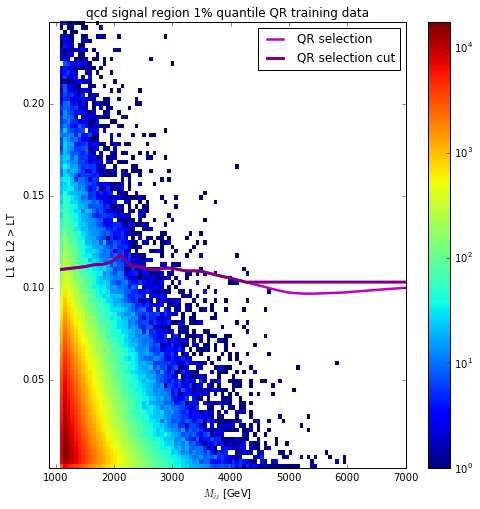

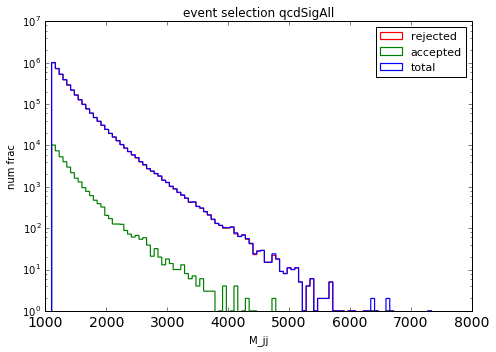

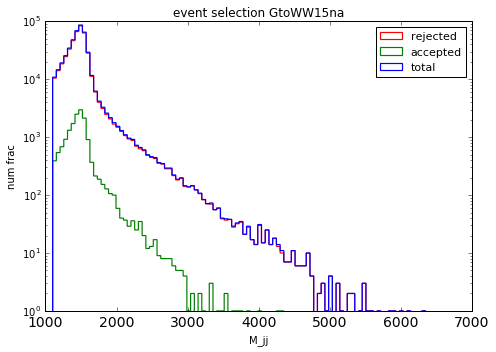

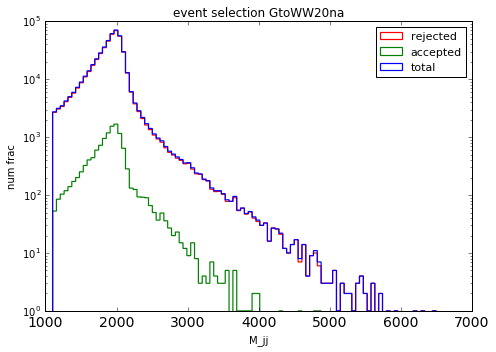

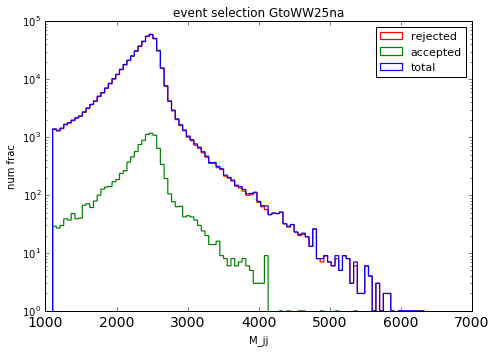

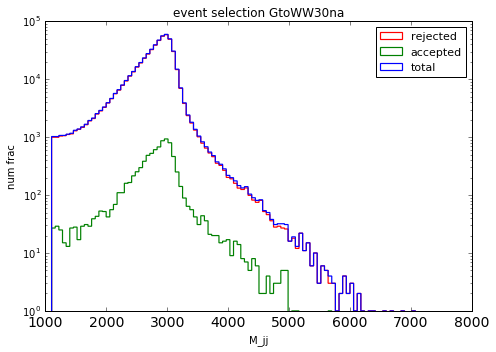

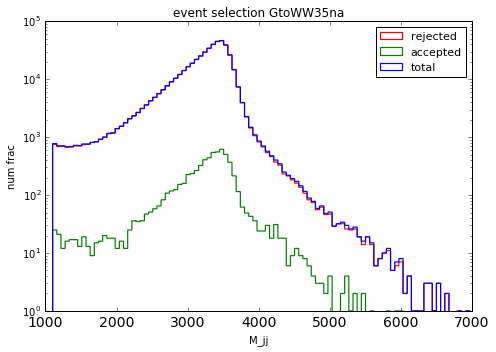

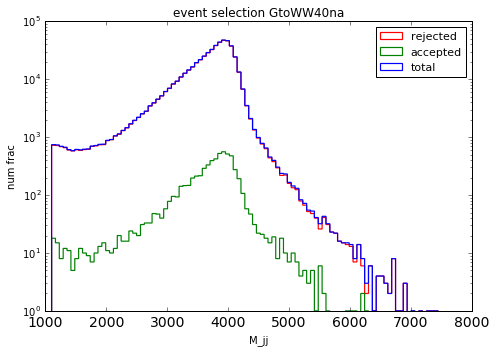

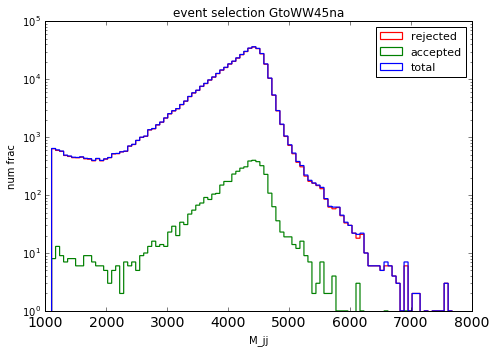

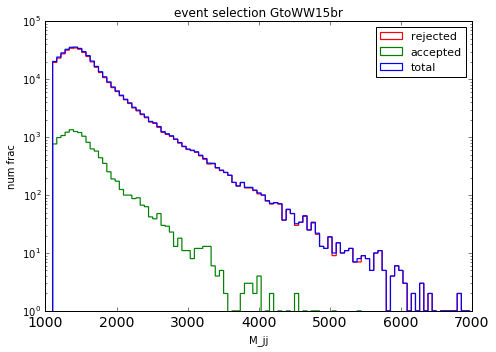

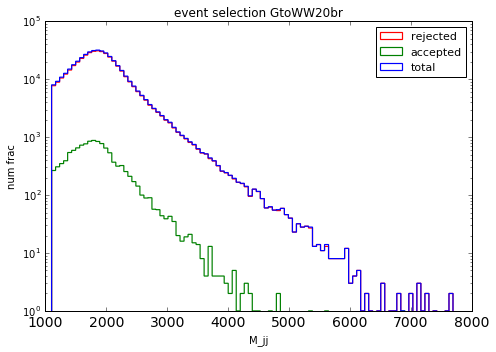

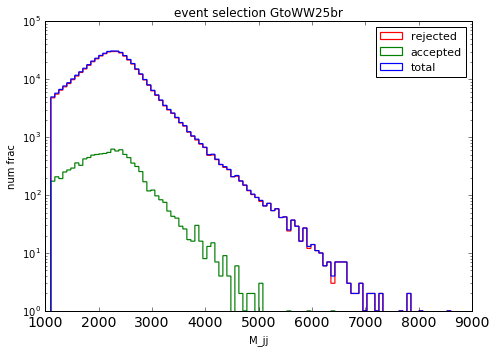

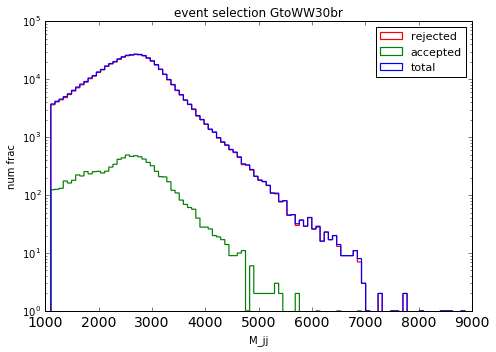

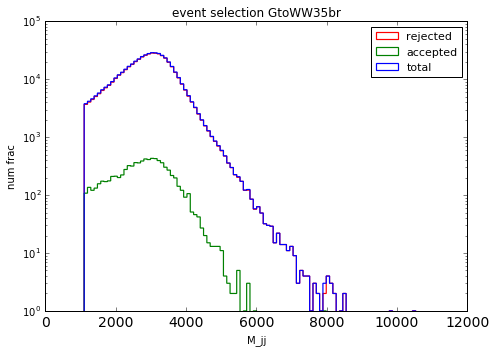

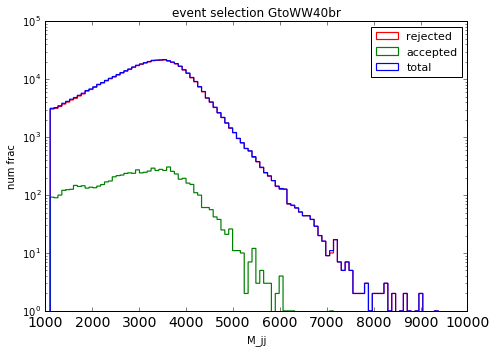

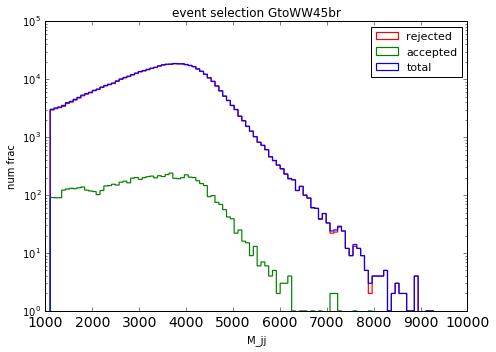

In [20]:
for q in quantiles: ### for each quantile
    
    quantile = pa.quantile_dict[q]
    eff = {} # key: dataset, values: list for all loss strategies
    
    for s in loss_strategies: ### for each loss strategy
        
        strategy = pa.loss_strategy_dict[s]
        
        # train QR
        model = qr.Quantile_Regression( quantile.val )
        y = strategy(qcd_data_train)
        model.fit( qcd_data_train['mJJ'], y )
        
        # get overflow bin (max accepted mjj) for regression cut
        sel = model.select_events( qcd_data_train['mJJ'], y ) # get selection for qcd training set
        max_acc_mjj = np.max(qcd_data_train['mJJ'][sel]) # get max mjj in accepted set
        
        # plot results
        fig_dir_ext = make_fig_dir( quantile, strategy )
        plot_qr_2d_hist( qcd_data_train, y, model, quantile, strategy, fig_dir_ext )
        
        # apply trained model to test datasets
        for n in all_samples:
            x = result_data[n]['mJJ']
            y = strategy(result_data[n])
            sel = model.select_events( x, y )    
            eff.setdefault(n,[]).append(100.0*(np.sum(sel)/float(sel.shape[0]))) # add efficiency for sample n and quantile q
            plot_acc_vs_rej_hist(n, result_data[n], sel, fig_dir_ext )
            
    analysis[q] = eff 

## transform results into pandas frame

In [24]:
frame_dict = { q : pd.DataFrame.from_dict( analysis[q] ) for q in quantiles }
analysis_frame = pd.concat([ frame_dict[q] for q in quantiles ],keys=quantiles,axis=1)

In [25]:
# write dataframe to pickle
analysis_frame.to_pickle(os.path.join(fig_dir_base,'qr_analysis_q99_0414.pkl'))

## read in dataframes

In [10]:
q1_dat = pd.read_pickle(os.path.join(fig_dir_base,'qr_analysis_q1_2_5_10_0403.pkl'))
q25_dat = pd.read_pickle(os.path.join(fig_dir_base,'qr_analysis_q25_50_75_90_0407.pkl'))
q99_dat = pd.read_pickle(os.path.join(fig_dir_base,'qr_analysis_q99_0414.pkl'))
analysis_frame = pd.concat([q1_dat,q25_dat,q99_dat],axis=1)
analysis_frame.head

<bound method DataFrame.head of          q1                                                              \
  GtoWW15br GtoWW15na GtoWW20br GtoWW20na GtoWW25br GtoWW25na GtoWW30br   
0  2.600369  2.790649  1.864618  1.837581  1.373223  1.095599  1.095246   
1  2.741045  2.983269  2.178490  2.116949  1.618306  1.433937  1.208370   
2  3.360277  3.666256  2.495051  2.453741  1.812215  1.435693  1.388340   
3  2.794528  3.048666  2.137686  2.081949  1.554868  1.257158  1.212895   
4  3.373965  3.512249  2.614995  2.537782  2.141458  1.960176  1.796615   

                                   ...            q99                        \
  GtoWW30na GtoWW35br GtoWW35na    ...      GtoWW25na  GtoWW30br  GtoWW30na   
0  0.865150  1.016515  0.790352    ...      99.757466  99.784653  99.761481   
1  0.956903  1.010298  0.685668    ...      99.766832  99.794320  99.801422   
2  1.078988  1.179984  0.824154    ...      99.881367  99.886876  99.894682   
3  0.980076  1.085313  0.784206    ...      99.

In [11]:
analysis_frame.columns.levels

FrozenList([[u'q1', u'q10', u'q2', u'q25', u'q5', u'q50', u'q75', u'q90', u'q99'], [u'GtoWW15br', u'GtoWW15na', u'GtoWW20br', u'GtoWW20na', u'GtoWW25br', u'GtoWW25na', u'GtoWW30br', u'GtoWW30na', u'GtoWW35br', u'GtoWW35na', u'GtoWW40br', u'GtoWW40na', u'GtoWW45br', u'GtoWW45na', u'qcdSigAll']])

In [12]:
quantiles = ['q1','q2','q5','q10','q25','q50','q75','q90','q99']
analysis_frame = analysis_frame.reindex(columns=quantiles,level=0) # reorder leading index of quantiles

In [13]:
analysis_frame.columns.levels

FrozenList([[u'q1', u'q2', u'q5', u'q10', u'q25', u'q50', u'q75', u'q90', u'q99'], [u'GtoWW15br', u'GtoWW15na', u'GtoWW20br', u'GtoWW20na', u'GtoWW25br', u'GtoWW25na', u'GtoWW30br', u'GtoWW30na', u'GtoWW35br', u'GtoWW35na', u'GtoWW40br', u'GtoWW40na', u'GtoWW45br', u'GtoWW45na', u'qcdSigAll']])

# plot results

In [35]:
# print table for all quantiles
print_table( analysis_frame, quantiles, loss_strategies ) # pass quantiles and loss strategies because dict not ordered 


++++++++++++++++++++++++++++++
	1% quantile


+-----------+---------+---------+--------------+--------------+--------------+
|   sample  | L1 > LT | L2 > LT | L1 + L2 > LT | L1 | L2 > LT | L1 & L2 > LT |
+-----------+---------+---------+--------------+--------------+--------------+
| qcdSigAll |   0.98  |   1.02  |     1.01     |     1.01     |     1.01     |
| GtoWW15na |   2.79  |   2.98  |     3.67     |     3.05     |     3.51     |
| GtoWW20na |   1.84  |   2.12  |     2.45     |     2.08     |     2.54     |
| GtoWW25na |   1.10  |   1.43  |     1.44     |     1.26     |     1.96     |
| GtoWW30na |   0.87  |   0.96  |     1.08     |     0.98     |     1.57     |
| GtoWW35na |   0.79  |   0.69  |     0.82     |     0.78     |     1.30     |
| GtoWW40na |   0.78  |   0.49  |     0.62     |     0.63     |     1.15     |
| GtoWW45na |   0.76  |   0.40  |     0.46     |     0.51     |     1.08     |
| GtoWW15br |   2.60  |   2.74  |     3.36     |     2.79     |     3.37     |
| Gto

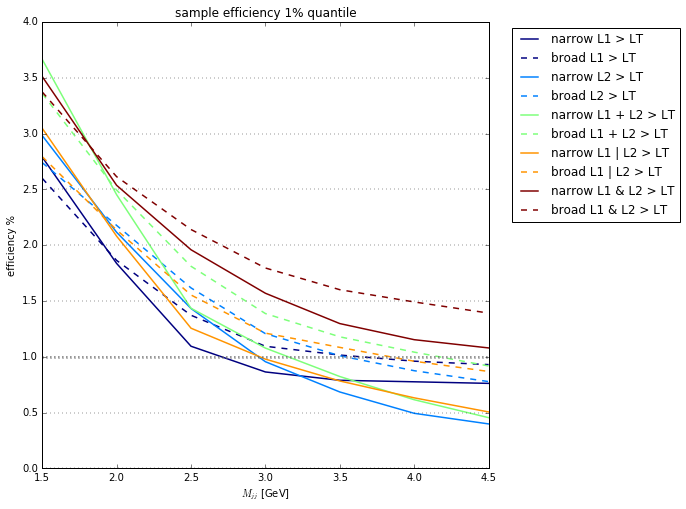

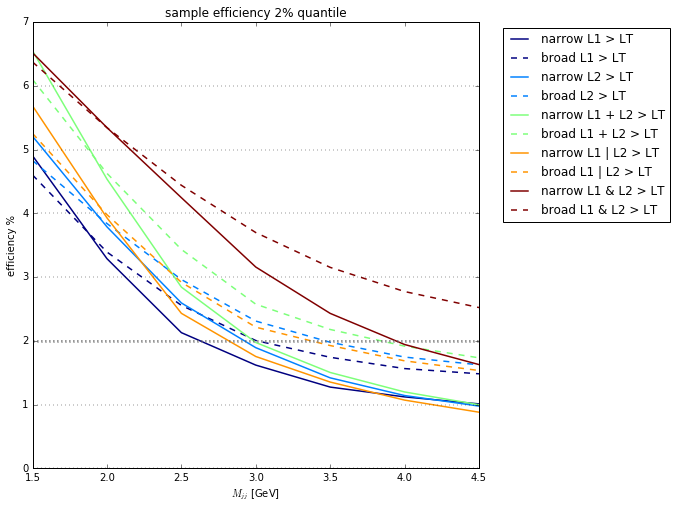

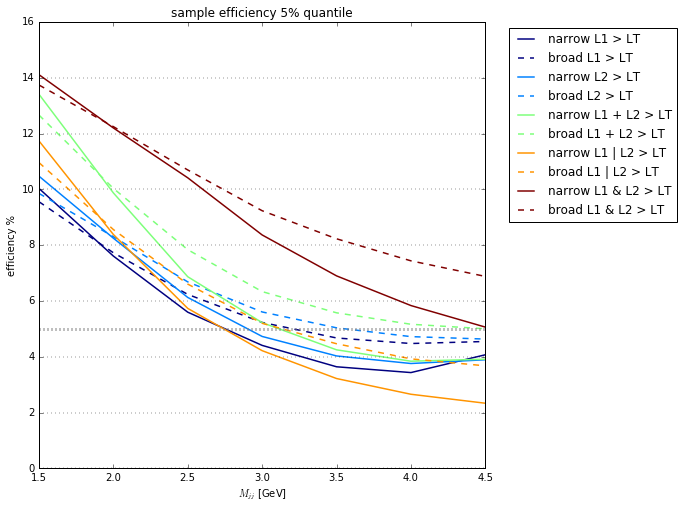

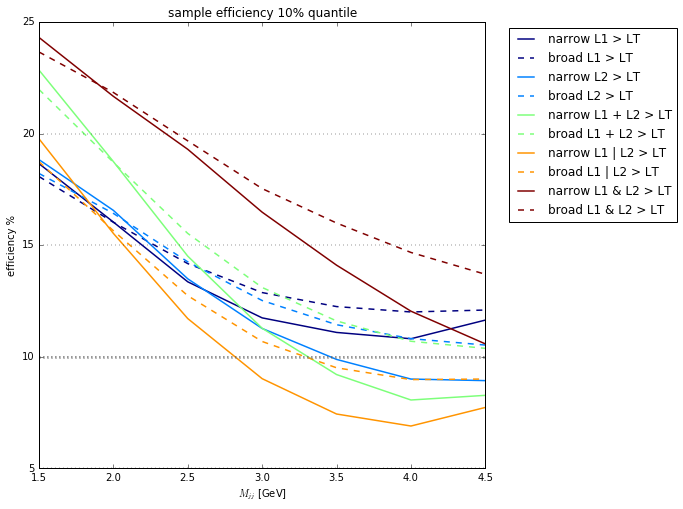

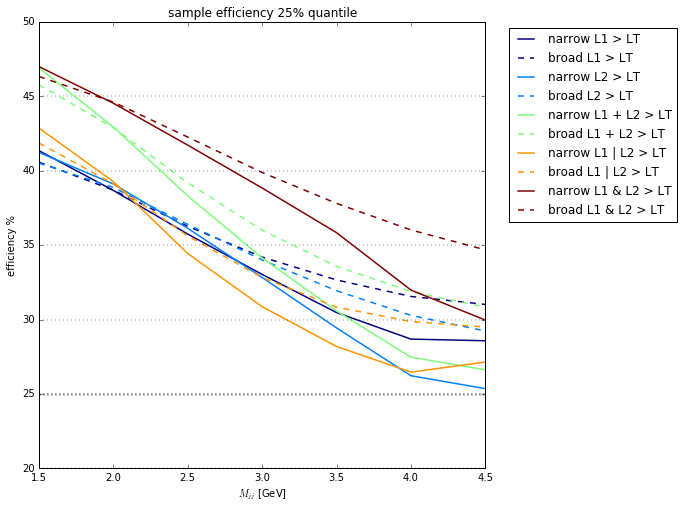

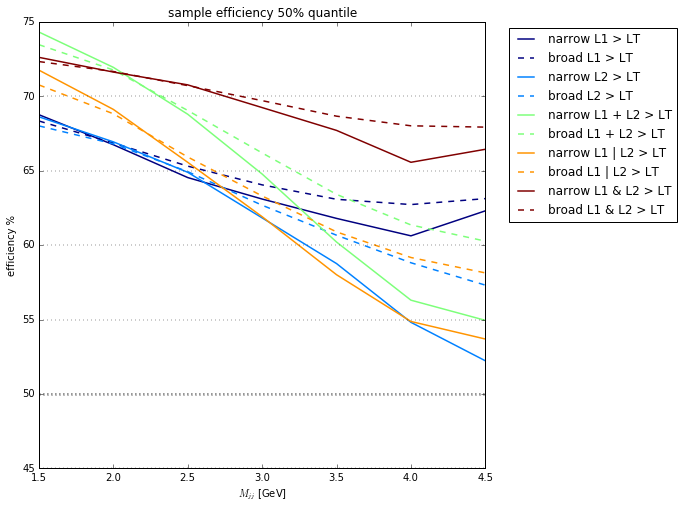

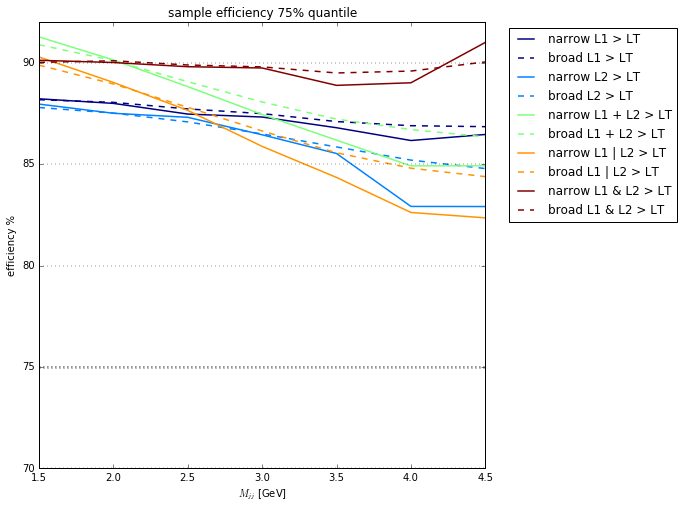

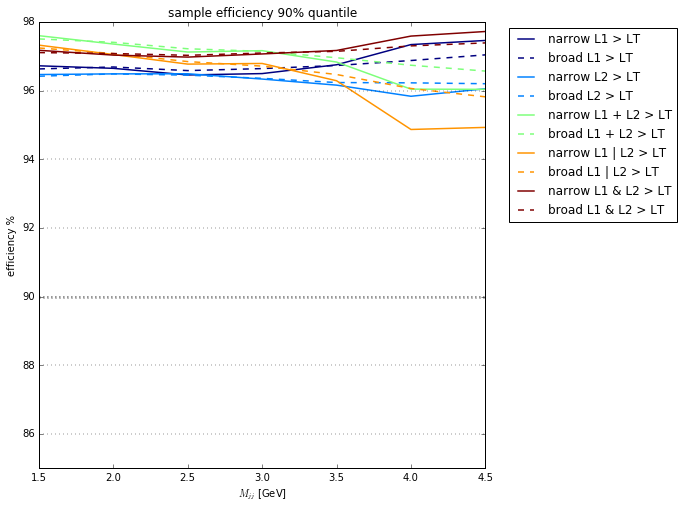

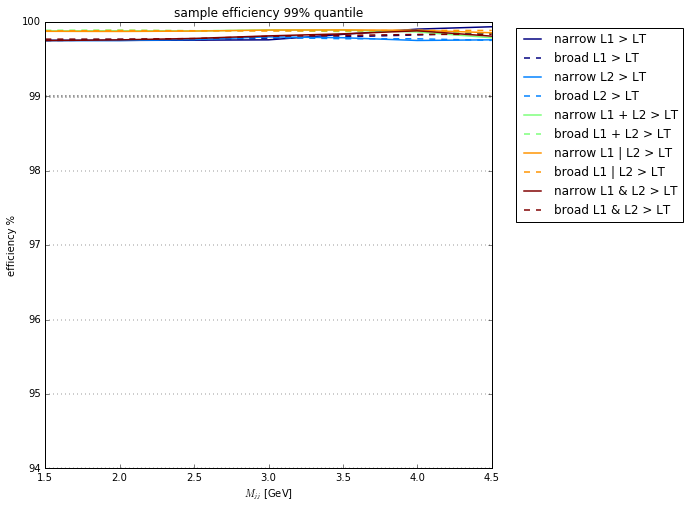

In [36]:
# print graph for all quantiles
plot_eff_vs_mjj( analysis_frame, quantiles, loss_strategies )

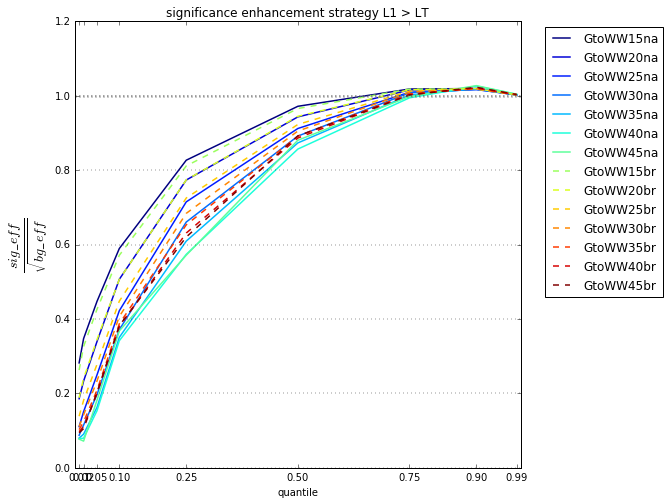

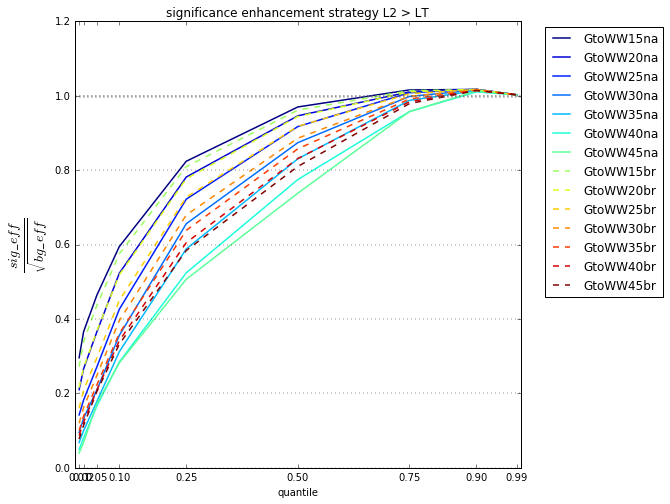

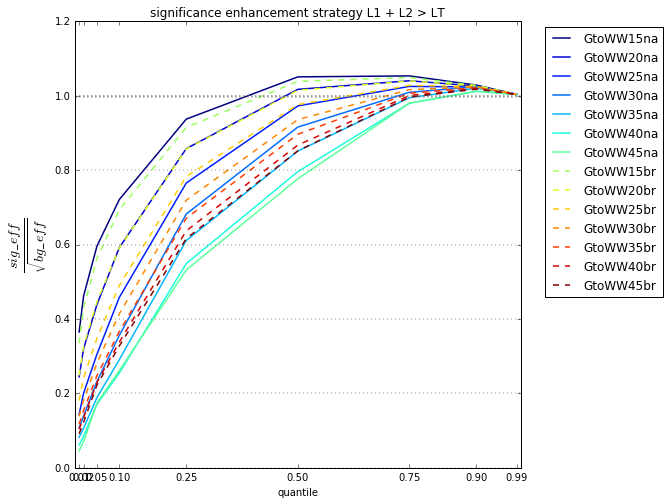

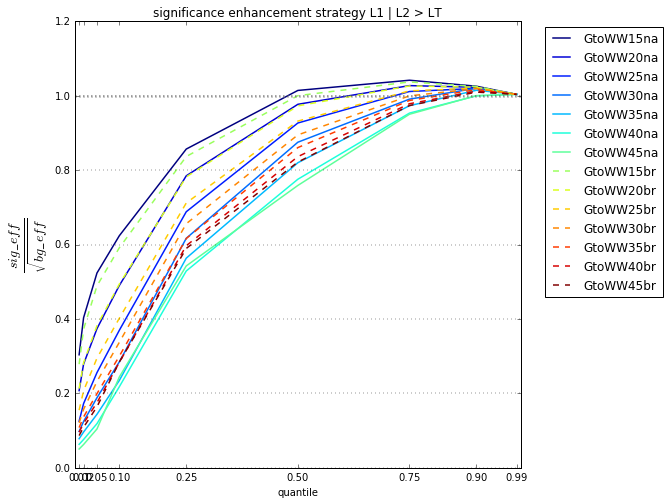

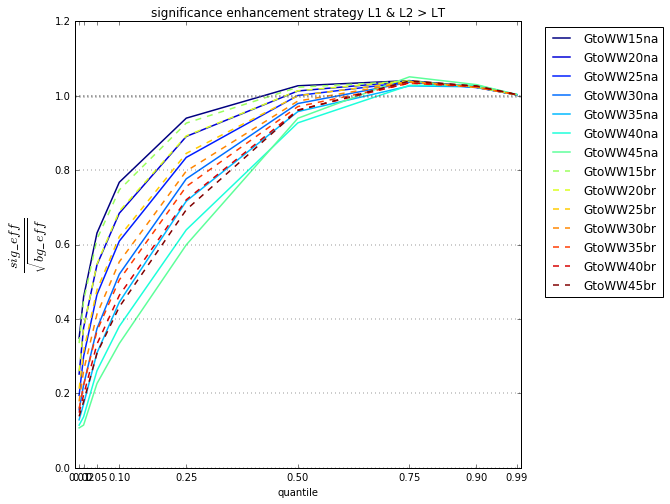

In [37]:
plot_eff_enhanced_vs_quantile( analysis_frame, quantiles, loss_strategies )

In [28]:
analysis_frame.columns.levels

FrozenList([[u'q1', u'q10', u'q2', u'q5'], [u'GtoWW15br', u'GtoWW15na', u'GtoWW20br', u'GtoWW20na', u'GtoWW25br', u'GtoWW25na', u'GtoWW30br', u'GtoWW30na', u'GtoWW35br', u'GtoWW35na', u'GtoWW40br', u'GtoWW40na', u'GtoWW45br', u'GtoWW45na', u'qcdSigAll']])

In [39]:
n_qcd_test = result_data[SM_sample].shape[0]

In [40]:
np.sqrt(n_qcd_test)

1988.0067907328687

## plot S / sqrt( B ) = 1 with max signal efficiency datapoint per quantile 

In [77]:
e_s = e_b = np.linspace(0.01,1.0,200)
z = [ s / np.sqrt(b) for s in e_s for b in e_b ]
X, Y = np.meshgrid(e_s,e_b)
Z = np.asarray(z).reshape(X.shape)

In [56]:
eff_B = []
max_eff_S = []
for quant in quantiles:
    eff = analysis_frame[quant].drop('qcdSigAll',axis=1)
    eff_B.append( pa.quantile_dict[quant].val )
    max_eff_S.append(eff.values.max())

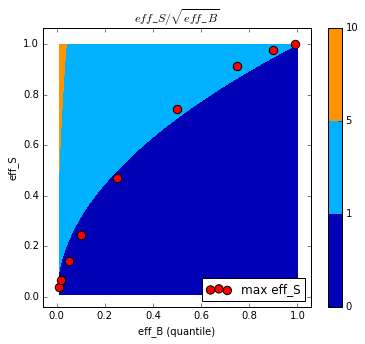

In [88]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 5))
plt.contourf(X,Y,Z,[0,1,5,10])
#plt.plot(e_b,e_s**2)
plt.title(r'$eff\_S / \sqrt{eff\_B}$')
plt.xlabel(r'eff_B (quantile)')
plt.ylabel(r'eff_S')
plt.colorbar()
plt.scatter(eff_B,np.asarray(max_eff_S)/100.0,c='r',s=70, label='max eff_S')
plt.legend(loc='lower right')
#plt.xlim(left=0.0,right=0.3)
#plt.ylim(bottom=0.0,top=0.5)
plt.savefig(os.path.join(fig_dir_base,'sig_over_sqrt_bg_1.png'))

In [70]:
eff_B

[0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]

In [59]:
np.asarray(max_eff_S)/100.

array([0.03666256, 0.06548863, 0.14115733, 0.24313665, 0.47008919,
       0.74331967, 0.91269597, 0.97726179, 0.99937551])

In [71]:
Z

array([[ 0.1       ,  0.02886751,  0.02085144,  0.01714986,  0.01490712,
         0.01336306,  0.01221694,  0.01132277,  0.01059998,  0.01      ],
       [ 1.2       ,  0.34641016,  0.2502173 ,  0.2057983 ,  0.17888544,
         0.16035675,  0.14660333,  0.13587324,  0.12719975,  0.12      ],
       [ 2.3       ,  0.66395281,  0.47958315,  0.39444675,  0.34286376,
         0.30735043,  0.28098972,  0.26042372,  0.24379951,  0.23      ],
       [ 3.4       ,  0.98149546,  0.70894901,  0.58309519,  0.50684207,
         0.45434411,  0.41537611,  0.38497419,  0.36039928,  0.34      ],
       [ 4.5       ,  1.29903811,  0.93831486,  0.77174363,  0.67082039,
         0.60133779,  0.5497625 ,  0.50952467,  0.47699905,  0.45      ],
       [ 5.6       ,  1.61658075,  1.16768072,  0.96039208,  0.83479871,
         0.74833148,  0.68414889,  0.63407514,  0.59359881,  0.56      ],
       [ 6.7       ,  1.9341234 ,  1.39704657,  1.14904052,  0.99877703,
         0.89532516,  0.81853528,  0.75862561

In [65]:
X

array([[0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ],
       [0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ],
       [0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ],
       [0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ],
       [0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ],
       [0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ],
       [0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ],
       [0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ],
       [0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ],
       [0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]])